In [92]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Load the dataset
df = pd.read_csv('Cleaned_MCS_TEAM_DATAX.csv')

# Convert 'DATETIME' column to datetime
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

# Sort by datetime in case it's unsorted
df = df.sort_values(by='DATETIME')

# Set 'DATETIME' as the index
df.set_index('DATETIME', inplace=True)

# Features to train on
features = ['TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']
target = ['TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']

# Split numerical and categorical features for preprocessing
numerical_features = ['TEMPERATURE (°C)', 'RAINFALL (mm)']
categorical_features = ['ACTUAL CONDITION', 'OCCURENCE OF FLOOD']

# Normalize numerical features
scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Time steps (e.g., past 7 days with 3 intervals/day = 21 steps)
time_steps = 21

# Prepare TimeseriesGenerator
data_gen = TimeseriesGenerator(df[features].values, df[target].values, length=time_steps, batch_size=64)

# Build the LSTM model
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(time_steps, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(150))
model.add(Dropout(0.2))
model.add(Dense(len(features)))  # Output layer with 4 neurons (one for each feature)

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the full dataset using TimeseriesGenerator
model.fit(data_gen, epochs=100)

# Forecast the next 7 days (3 intervals per day = 21 steps total)
def forecast_weather(model, data, steps=21):
    forecast = []
    last_sequence = data[-steps:]  # Get the last sequence from the dataset
    for _ in range(steps):  # Predict the next 7 days
        prediction = model.predict(last_sequence[np.newaxis, :, :])
        forecast.append(prediction[0])
        last_sequence = np.append(last_sequence[1:], prediction, axis=0)  # Slide the window
    return np.array(forecast)

# Forecast from 2024-09-01 to 2024-09-07 (21 intervals)
forecast_data = forecast_weather(model, df[features].values)

# Inverse transform the forecasted numerical values
forecast_data[:, :2] = scaler.inverse_transform(forecast_data[:, :2])

# Create a DataFrame for the forecasted data
forecast_df = pd.DataFrame(forecast_data, columns=features)


# Set forecast dates (from 2024-09-01 to 2024-09-07, 3 intervals per day)
forecast_dates = pd.date_range(start=df.index.max() + pd.Timedelta(hours=8), periods=n_future, freq='8H')
forecast_df['DATETIME'] = forecast_dates

# Print the forecasted values
print(forecast_df[['DATETIME', 'TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURENCE OF FLOOD']])


Epoch 1/100


2024-10-17 12:30:59.266005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-17 12:30:59.266407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-17 12:30:59.266931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 [==============================] - 2s 44ms/step - loss: 1.3356
Epoch 2/100
29/29 [==============================] - 1s 43ms/step - loss: 0.8942
Epoch 3/100
29/29 [==============================] - 1s 44ms/step - loss: 0.8778
Epoch 4/100
29/29 [==============================] - 1s 44ms/step - loss: 0.8524
Epoch 5/100
29/29 [==============================] - 1s 44ms/step - loss: 0.8530
Epoch 6/100
29/29 [==============================] - 1s 41ms/step - loss: 0.8409
Epoch 7/100
29/29 [==============================] - 1s 43ms/step - loss: 0.7967
Epoch 8/100
29/29 [==============================] - 1s 44ms/step - loss: 0.8138
Epoch 9/100
29/29 [==============================] - 1s 45ms/step - loss: 0.8076
Epoch 10/100
29/29 [==============================] - 1s 44ms/step - loss: 0.8017
Epoch 11/100
29/29 [==============================] - 1s 41ms/step - loss: 0.8161
Epoch 12/100
29/29 [==============================] - 1s 40ms/step - loss: 0.8293
Epoch 13/100
29/29 [=================

2024-10-17 12:33:00.219233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-17 12:33:00.219703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-17 12:33:00.220352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 8ms/step
              DATETIME  TEMPERATURE (°C)  RAINFALL (mm)  ACTUAL CONDITION  \
0  2024-09-01 00:00:00         34.187592       1.079259          4.687307   
1  2024-09-01 08:00:00         32.930405       1.120809          3.604744   
2  2024-09-01 16:00:00         32.933559       1.207492          3.421248   
3  2024-09-02 00:00:00         35.902802       1.453885          5.343926   
4  2024-09-02 08:00:00         34.564812       0.900334          4.447316   
5  2024-09-02 16:00:00         36.660072       0.580177          5.072498   
6  2024-09-03 00:00:00         34.684772       0.121115          4.542510   
7  2024-09-03 08:00:00         34.269043       0.010794          4.343798   
8  2024-09-03 16:00:00         35.032581       0.175764          4.632189   
9  2024-09-04 00:00:00         35.744743       0.345777          4.965811   
10 2024-09-04 08:00:00         35.997124       0.000548          5.051324   
11 2024-09-04 16:00:00   

/var/folders/j3/kwprsg3s3_zf9_90gxwcknm00000gn/T/ipykernel_88614/3629859215.py:72: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_dates = pd.date_range(start=df.index.max() + pd.Timedelta(hours=8), periods=n_future, freq='8H')


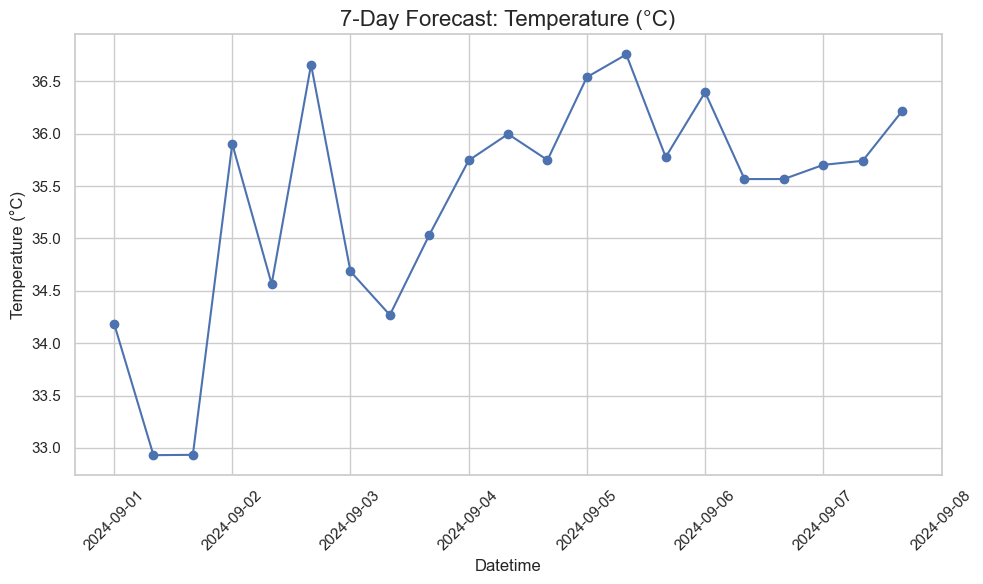

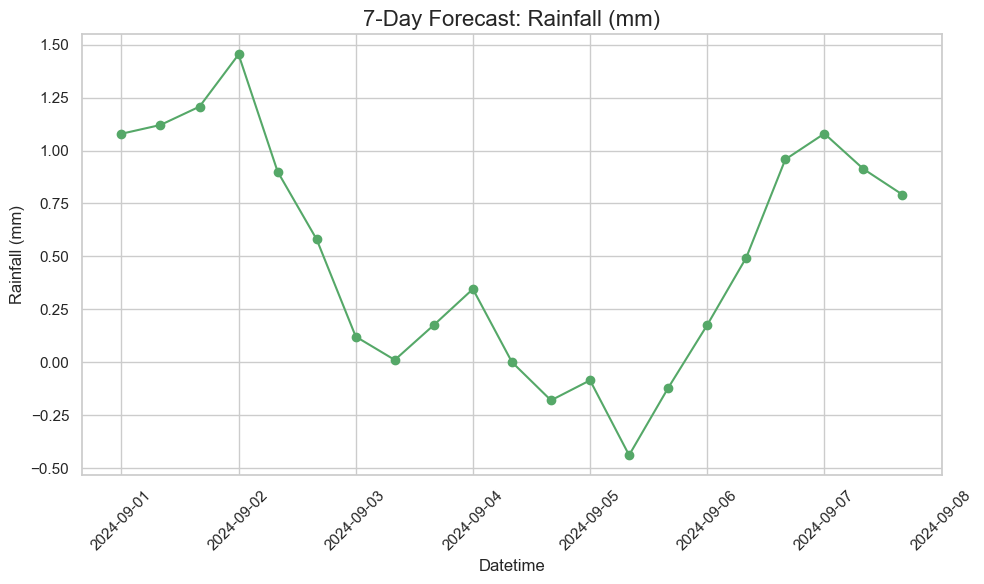

Index(['TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION',
       'OCCURENCE OF FLOOD', 'DATETIME'],
      dtype='object')


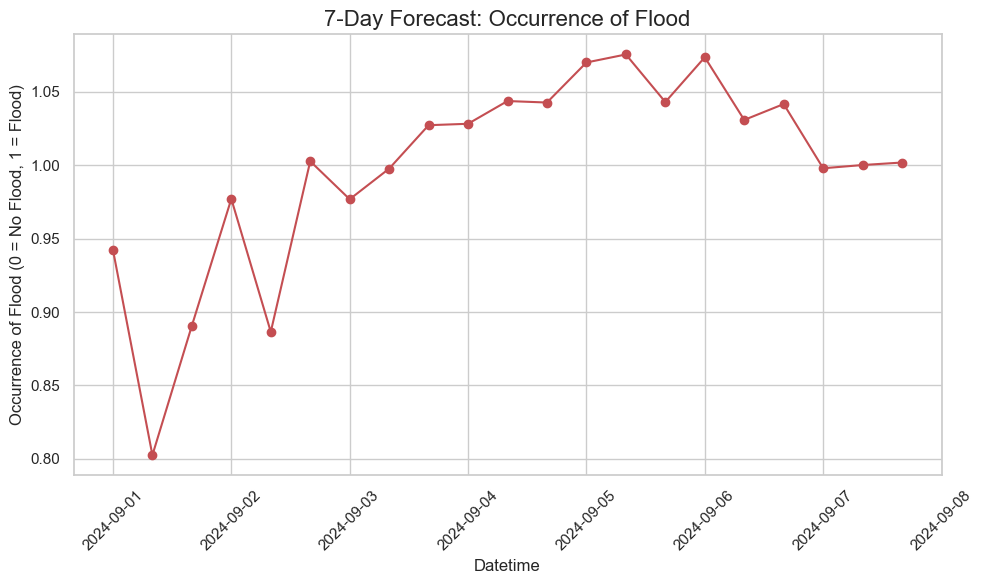

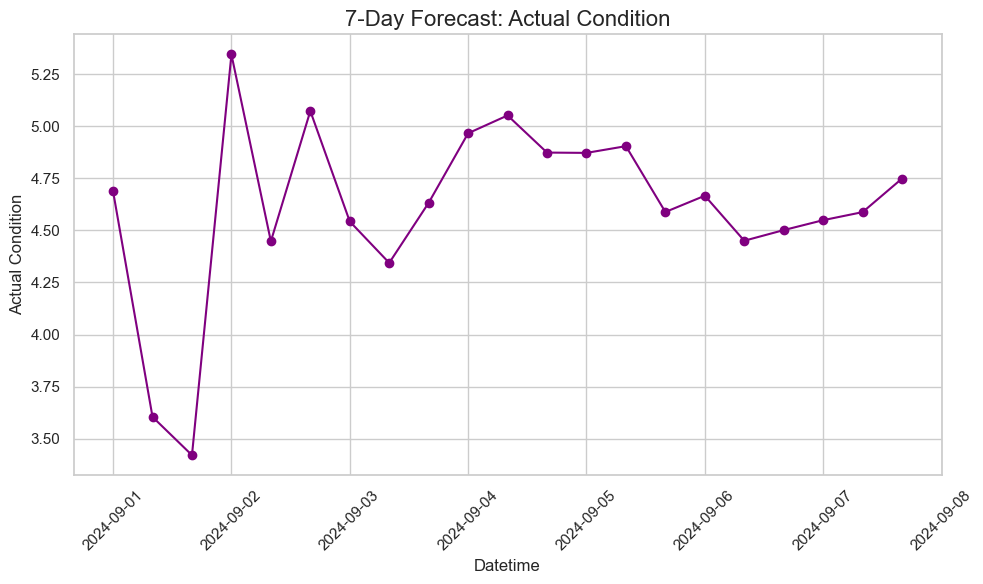

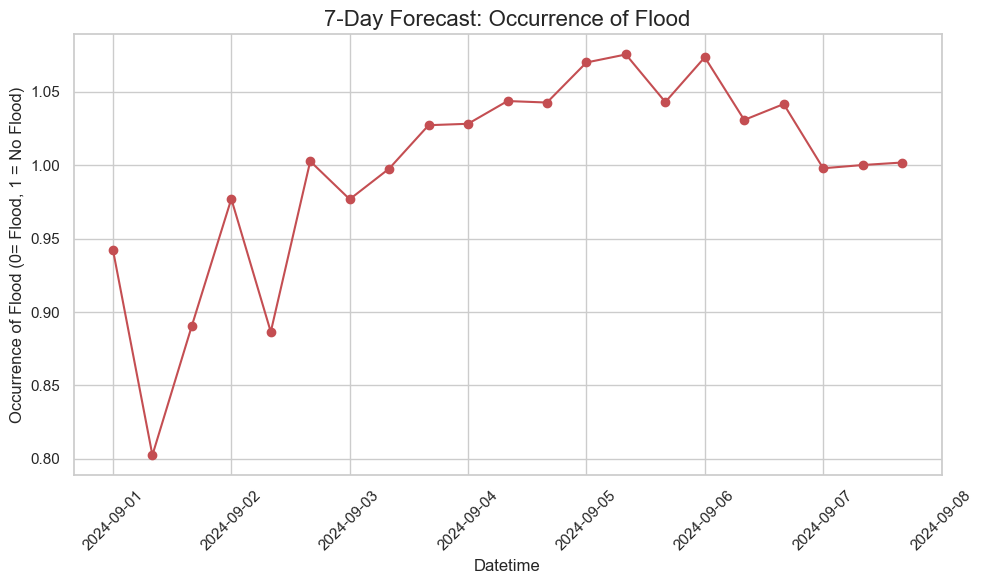

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Forecast dataframe already created
# forecast_df[['DATETIME', 'TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION', 'OCCURRENCE OF FLOOD']]

# Set the style for the plots
sns.set(style='whitegrid')

# Plot 'TEMPERATURE (°C)'
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['DATETIME'], forecast_df['TEMPERATURE (°C)'], marker='o', color='b')
plt.title('7-Day Forecast: Temperature (°C)', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 'RAINFALL (mm)'
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['DATETIME'], forecast_df['RAINFALL (mm)'], marker='o', color='g')
plt.title('7-Day Forecast: Rainfall (mm)', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Rainfall (mm)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print column names to verify
print(forecast_df.columns)

# Adjust the plotting code based on the correct column name

# Plot 'OCCURRENCE OF FLOOD' (check for correct column name in the DataFrame)
if 'OCCURENCE OF FLOOD' in forecast_df.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_df['DATETIME'], forecast_df['OCCURENCE OF FLOOD'], marker='o', color='r')
    plt.title('7-Day Forecast: Occurrence of Flood', fontsize=16)
    plt.xlabel('Datetime', fontsize=12)
    plt.ylabel('Occurrence of Flood (0 = No Flood, 1 = Flood)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'OCCURRENCE OF FLOOD' not found in forecast_df.")


# Plot 'ACTUAL CONDITION'
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['DATETIME'], forecast_df['ACTUAL CONDITION'], marker='o', color='purple')
plt.title('7-Day Forecast: Actual Condition', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Actual Condition', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 'OCCURRENCE OF FLOOD'
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['DATETIME'], forecast_df['OCCURENCE OF FLOOD'], marker='o', color='r')
plt.title('7-Day Forecast: Occurrence of Flood', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Occurrence of Flood (0= Flood, 1 = No Flood)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()




In [94]:
import pandas as pd

# Load the CSV file named 'Cleaned_MCS_TEAM_DATA2.csv'
data = pd.read_csv('Cleaned_MCS_TEAM_DATA2.csv')

# Convert 'DATETIME' column to datetime object for filtering
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

# Extract data from 'DATETIME' starting from '2024-09-01' to the last available date
start_date = '2024-09-01'
extracted_data = data[data['DATETIME'] >= start_date]

# Save the extracted data to a new CSV file named 'Actual.csv'
extracted_data.to_csv('Actual.csv', index=False)

print("Data extraction complete. The extracted data has been saved to 'Actual.csv'.")


Data extraction complete. The extracted data has been saved to 'Actual.csv'.


Actual Data Columns: Index(['DATETIME', 'TEMPERATURE (°C)', 'RAINFALL (mm)', 'ACTUAL CONDITION',
       'OCCURENCE OF FLOOD'],
      dtype='object')


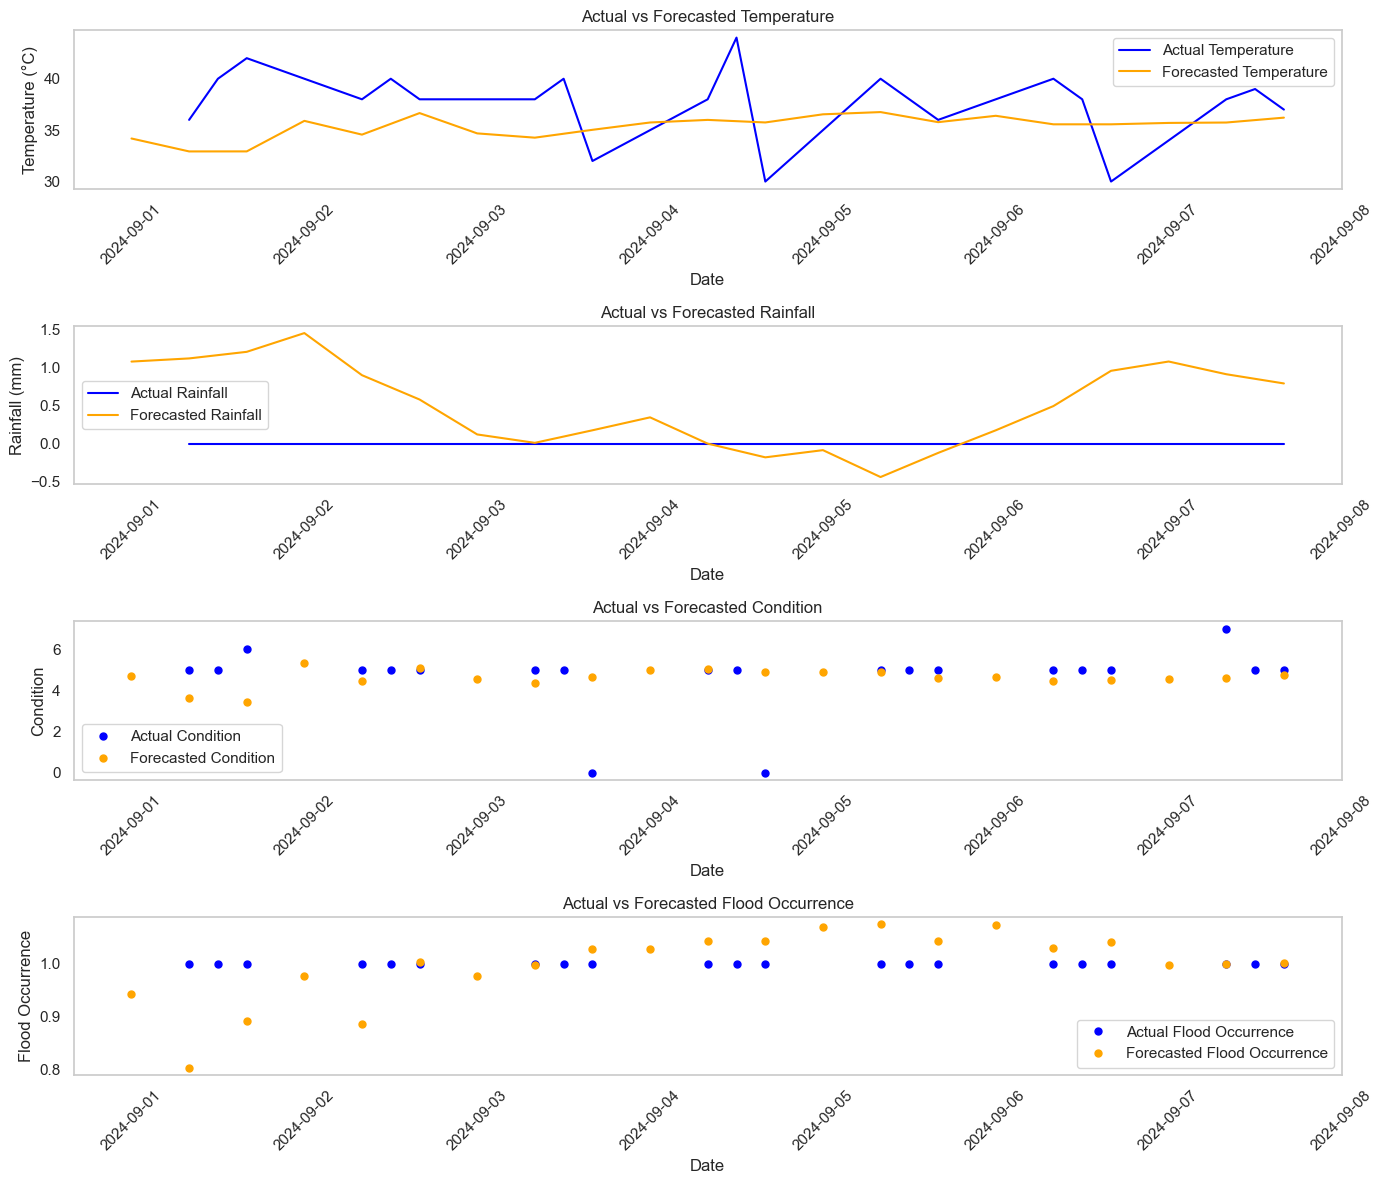

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the actual data from 'Actual.csv'
actual_data = pd.read_csv('Actual.csv')

# Check the columns of the actual data
print("Actual Data Columns:", actual_data.columns)

# Assuming forecast_df is already defined and contains the forecasted data
# For demonstration purposes, you may need to define it or load it from another source
# Example structure of forecast_df for context (replace this with actual loading code):
# forecast_df = pd.read_csv('Forecasted_Data.csv')  # Load your forecast data here
# print("Forecast Data Columns:", forecast_df.columns)

# Check the columns of the forecasted data
# print("Forecast Data Columns:", forecast_df.columns)

# Convert 'DATETIME' columns to datetime objects for proper plotting
actual_data['DATETIME'] = pd.to_datetime(actual_data['DATETIME'])

# Ensure forecast_df is defined and structured correctly
# Assuming forecast_df is defined with a proper structure
# forecast_df['DATETIME'] = pd.to_datetime(forecast_df['DATETIME'])

# Check if DATETIME column exists in forecast_df
if 'DATETIME' not in forecast_df.columns:
    print("Error: 'DATETIME' column not found in forecast_df")
else:
    forecast_df['DATETIME'] = pd.to_datetime(forecast_df['DATETIME'])

# Set the 'DATETIME' column as the index for both DataFrames
actual_data.set_index('DATETIME', inplace=True)
forecast_df.set_index('DATETIME', inplace=True)

# Create a figure with four subplots for each feature
plt.figure(figsize=(14, 12))

# Subplot 1: Temperature
plt.subplot(4, 1, 1)
plt.plot(actual_data.index, actual_data['TEMPERATURE (°C)'], label='Actual Temperature', color='blue')
plt.plot(forecast_df.index, forecast_df['TEMPERATURE (°C)'], label='Forecasted Temperature', color='orange')
plt.title('Actual vs Forecasted Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 2: Rainfall
plt.subplot(4, 1, 2)
plt.plot(actual_data.index, actual_data['RAINFALL (mm)'], label='Actual Rainfall', color='blue')
plt.plot(forecast_df.index, forecast_df['RAINFALL (mm)'], label='Forecasted Rainfall', color='orange')
plt.title('Actual vs Forecasted Rainfall')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 3: Actual Condition
plt.subplot(4, 1, 3)
plt.plot(actual_data.index, actual_data['ACTUAL CONDITION'], label='Actual Condition', marker='o', linestyle='None', color='blue', markersize=5)
plt.plot(forecast_df.index, forecast_df['ACTUAL CONDITION'], label='Forecasted Condition', marker='o', linestyle='None', color='orange', markersize=5)
plt.title('Actual vs Forecasted Condition')
plt.xlabel('Date')
plt.ylabel('Condition')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Subplot 4: Occurrence of Flood
plt.subplot(4, 1, 4)
plt.plot(actual_data.index, actual_data['OCCURENCE OF FLOOD'], label='Actual Flood Occurrence', marker='o', linestyle='None', color='blue', markersize=5)
plt.plot(forecast_df.index, forecast_df['OCCURENCE OF FLOOD'], label='Forecasted Flood Occurrence', marker='o', linestyle='None', color='orange', markersize=5)
plt.title('Actual vs Forecasted Flood Occurrence')
plt.xlabel('Date')
plt.ylabel('Flood Occurrence')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
